# Feature Selection

@roman_avj
30 oct 2023

Feature Selection


In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from sklearn.pipeline import Pipeline, make_pipeline
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees
from scipy.integrate import simpson

# Data

In [2]:
# read
df_model = pd.read_parquet('../../data/data2analyze_clean_v2.parquet')
df_model.info()

[FATAL] 2023-11-01 01:35:04.494 Aws::Config::ConfigFileProfileFSM [0x200834280] Unknown parser error: unexpected state 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73938 entries, 0 to 73937
Columns: 141 entries, id to cosine_tmonth
dtypes: datetime64[us](2), float64(122), int32(1), int64(4), object(9), string(3)
memory usage: 79.3+ MB


In [3]:
# add if has maintenance
df_model['has_maintenance'] = df_model['cost_of_maintenance'].apply(lambda x: 1 if x > 0 else 0)

In [4]:
# clip columns with 'lag' up to 99 percentile
vars_lag = df_model.columns[df_model.columns.str.contains('lag')]
df_model[vars_lag] = df_model[vars_lag].clip(upper=df_model[vars_lag].quantile(0.99), axis=1)

In [5]:
print(df_model.columns.tolist())

['id', 'marketplace', 'first_observed_date', 'last_observed_date', 'count_repeated', 'time2event', 'event', 'id_sepomex', 'listing_type', 'property_type', 'is_development', 'is_exterior', 'is_penthouse', 'first_price', 'last_price', 'surface_total', 'num_bathrooms', 'num_parking_lots', 'num_bedrooms', 'cost_of_maintenance', 'is_new_property_prob', 'prediction_price', 'prediction_price_per_square_meter', 'longitude', 'latitude', 'has_balcony', 'has_elevator', 'has_garden', 'has_gym', 'has_luxury_features', 'has_pool', 'has_studio', 'has_surveillance', 'has_terrace', 'has_visitors_parking', 'has_washing_area', 'pets_allowed', 'page_on_marketplace', 'seller', 'tyear_start', 'tmonth_start', 'tquarter_start', 'available_secondary', 'delta_available_secondary', 'delta_available_secondary_lag1', 'delta_available_secondary_lag2', 'delta_available_secondary_lag3', 'available_secondary_lag1', 'available_secondary_lag2', 'available_secondary_lag3', 'ratio_available_to_total', 'delta_ratio_availab

# Select columns

In [6]:
# select columns
vars_x_categorical = ['listing_type', 'property_type']
vars_x_discrete = ['num_bedrooms', 'num_bathrooms', 'num_parking_lots', 'sine_tmonth', 'cosine_tmonth']
vars_x_numerical = ['woe_marketplace', 'woe_seller', 'woe_id_sepomex', 
    'first_price', 'diff_first_prediction', 
    'prediction_price_per_square_meter',
    'delta_available_secondary_lag1', 'delta_available_secondary_lag2', 'delta_available_secondary_lag3', 
    'delta_capital_gain_lag6', 'delta_capital_gain_lag3', 'delta_capital_gain_lag2', 'delta_capital_gain_lag1', 
    'delta_median_cap_rate_lag2', 'delta_median_cap_rate_lag1',
    'median_cap_rate_lag3', 'median_cap_rate_lag2', 'median_cap_rate_lag1',
    'surface_total', 'page_on_marketplace', 'views',
    'is_new_property_prob', 'total_cost_of_living', 'green_index', 'days_active',
    'relative_cost_of_living']
vars_x_binary = ['is_exterior', 'has_gym', 'has_studio', 'pets_allowed', 'has_maintenance']

vars_x_names = vars_x_categorical + vars_x_numerical + vars_x_binary + vars_x_discrete

# corroborate there are not duplicates in the vars_x_names
print(len(vars_x_names))
print(len(set(vars_x_names)))

38
38


## Prepare data

In [7]:
# get y data as sksurv need
data_y = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# get x data
data_x = (
    df_model.copy()
    .assign(prediction_price=lambda x: x['first_price'].div(1e+6))
    .astype({col: 'category' for col in vars_x_categorical})
    .astype({col: np.float64 for col in vars_x_numerical})
    .astype({col: np.int8 for col in vars_x_binary})
    [vars_x_names]
)
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73938 entries, 0 to 73937
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   listing_type                       73938 non-null  category
 1   property_type                      73938 non-null  category
 2   woe_marketplace                    73938 non-null  float64 
 3   woe_seller                         73938 non-null  float64 
 4   woe_id_sepomex                     73938 non-null  float64 
 5   first_price                        73938 non-null  float64 
 6   diff_first_prediction              73938 non-null  float64 
 7   prediction_price_per_square_meter  73938 non-null  float64 
 8   delta_available_secondary_lag1     73938 non-null  float64 
 9   delta_available_secondary_lag2     73938 non-null  float64 
 10  delta_available_secondary_lag3     73938 non-null  float64 
 11  delta_capital_gain_lag6            73938 

In [8]:
# one hot encoding
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.info()

colnames_x_numeric = data_x_numeric.columns
data_x_numeric = data_x_numeric.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73938 entries, 0 to 73937
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   listing_type=for-sale              73938 non-null  float64
 1   property_type=house                73938 non-null  float64
 2   woe_marketplace                    73938 non-null  float64
 3   woe_seller                         73938 non-null  float64
 4   woe_id_sepomex                     73938 non-null  float64
 5   first_price                        73938 non-null  float64
 6   diff_first_prediction              73938 non-null  float64
 7   prediction_price_per_square_meter  73938 non-null  float64
 8   delta_available_secondary_lag1     73938 non-null  float64
 9   delta_available_secondary_lag2     73938 non-null  float64
 10  delta_available_secondary_lag3     73938 non-null  float64
 11  delta_capital_gain_lag6            73938 non-null  flo

In [9]:
# boxcox
location_cols_boxcox = [colnames_x_numeric.get_loc(col) for col in vars_x_numerical]

data_x_numeric_aux = data_x_numeric[:, location_cols_boxcox] / 1e+6
data_x_numeric_aux = PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(data_x_numeric_aux)
data_x_numeric[:,location_cols_boxcox] = data_x_numeric_aux

In [10]:
# scale
location_cols_scale = [colnames_x_numeric.get_loc(col) for col in vars_x_discrete]
data_x_numeric_aux = data_x_numeric[:, location_cols_scale]
data_x_numeric_aux = StandardScaler().fit_transform(data_x_numeric_aux)
data_x_numeric[:,location_cols_scale] = data_x_numeric_aux

## Split data

In [11]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.2, random_state=42, stratify=data_x['listing_type']
)

## Elastic Net Cox Model

### Naive

In [12]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.05)
cox_elastic_net.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.05, l1_ratio=0.9)

In [13]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(12, 12))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], "-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

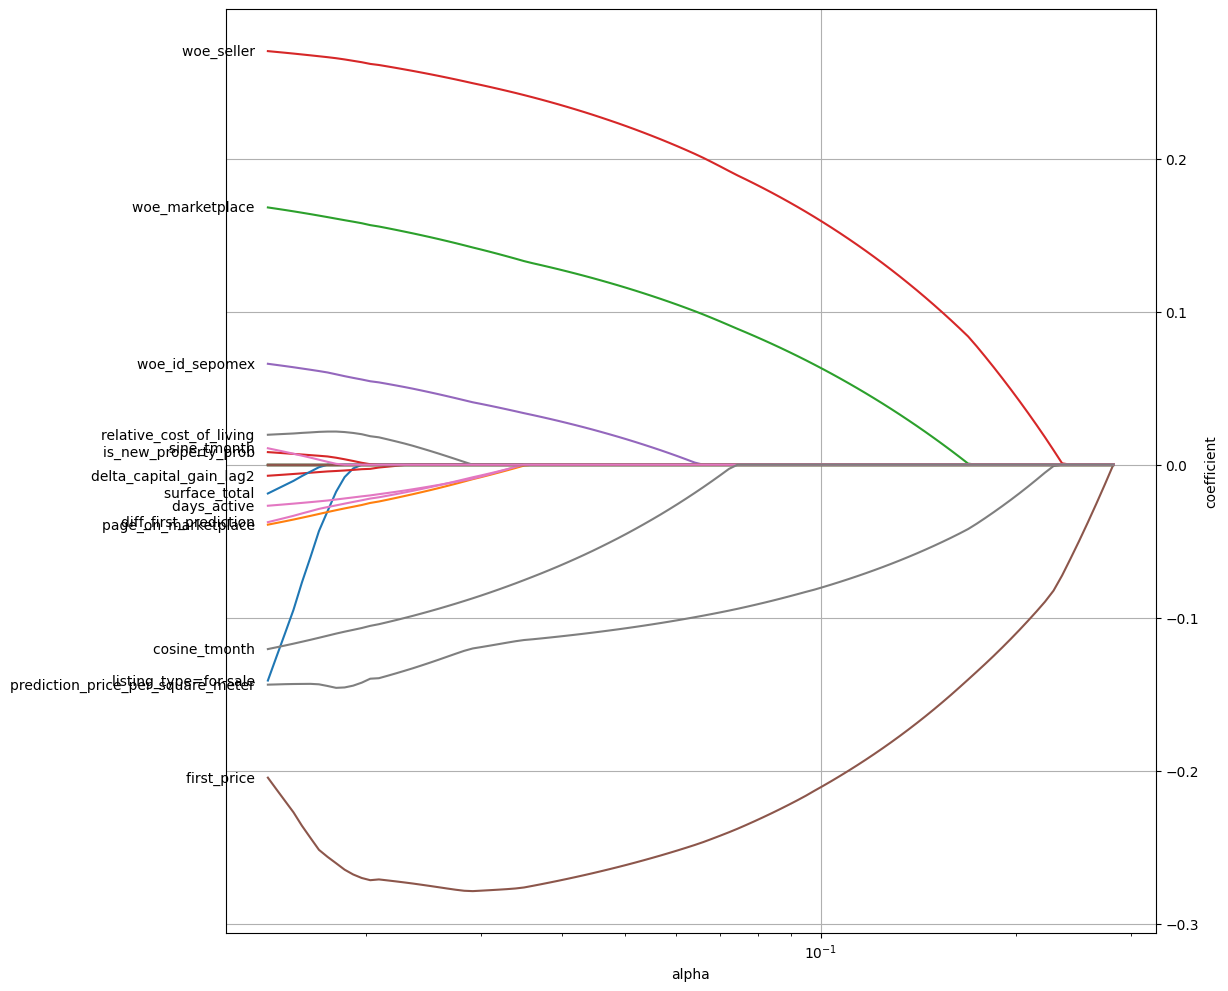

In [18]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=colnames_x_numeric, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=15)

### Random Forest

In [26]:
from sklearn.inspection import permutation_importance

rsf = ExtraSurvivalTrees(
    n_estimators=100, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=42
)
rsf.fit(X_train, y_train)

ExtraSurvivalTrees(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                   random_state=42)

In [27]:
result = permutation_importance(rsf, X_train[:1000], y_train[:1000], n_repeats=15, random_state=42)

In [29]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=colnames_x_numeric,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
listing_type=for-sale,0.043724,0.004356
woe_marketplace,0.037865,0.003385
woe_seller,0.034599,0.005597
first_price,0.018916,0.002478
cosine_tmonth,0.018079,0.002360
sine_tmonth,0.013061,0.003958
prediction_price_per_square_meter,0.007693,0.001246
woe_id_sepomex,0.006576,0.001787
page_on_marketplace,0.005610,0.000796
surface_total,0.003839,0.000490


# Conclusions

## linear model

Using the elastic net, I see that the most important features are:
- woe_seller
- first_price
- prediction_price_per_square_meter
- listing_type
- woe_marketplace
- woe_id_sepomex
- relative_cost_of_living
- sine_tmonth
- cosine_tmonth
- page_on_marketplace
- diff_first_prediction
- is_new_property_type
- surface_total
- days_active
- delta_capital_gain_lag2

## non-linear feature importance

Using random forest to select features, we can see that the most important features are:
- listing_type
- woe_marketplace
- woe_seller
- first_price
- cosine_tmonth
- sine_tmonth
- prediction_price_per_square_meter
- woe_id_sepomex
- page_on_marketplace
- surface_total
- has_gym
- pets_allowed
- total_cost_of_living
- is_new_property_type
- num_bathrooms
- diff_first_prediction